In [ ]:
pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial
import os
import numpy as np
import pandas as pd


# import keras
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data = pd.read_csv('/content/drive/MyDrive/Folds.csv')

img_dir = '/content/drive/MyDrive/BreaKHis/BreakHis_v1'
class_names = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma',
       'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma',
       'papillary_carcinoma']


In [ ]:
model_handle_map = {"efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", 
                   "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4", 
                   "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"}
model_image_size = {"efficientnetv2-b0": 224, 
                   "inception_v3": 299, 
                   "resnet_v2_50": 224}



In [ ]:
model_handle_map['resnet_v2_50']

'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[5])
data["label_int"]=data["label"]
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(10)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-006.png
6,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-007.png
7,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-008.png
8,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-009.png
9,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,adenosis,SOB_B_A-14-22549AB-100-010.png


In [ ]:
data['label_int'].replace(to_replace=['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma',
       'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma',
       'papillary_carcinoma'], value=[0,1, 2, 3, 4, 5,6,7], inplace=True)

In [ ]:
data.head(10)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-006.png
6,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-007.png
7,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-008.png
8,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-009.png
9,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,adenosis,0,SOB_B_A-14-22549AB-100-010.png


In [ ]:
adenosis=data[data["label"]=="adenosis"]
fibroadenoma=data[data["label"]=="fibroadenoma"]
phyllodes_tumor=data[data["label"]=="phyllodes_tumor"]
tubular_adenoma=data[data["label"]=="tubular_adenom"]
ductal_carcinoma=data[data["label"]=="ductal_carcinoma"]
lobular_carcinoma=data[data["label"]=="lobular_carcinoma"]
mucinous_carcinoma=data[data["label"]=="mucinous_carcinoma"]
papillary_carcinoma=data[data["label"]=="papillary_carcinoma"]

In [ ]:
adenosis.shape

(2220, 7)

In [ ]:
data["path"][0]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

In [ ]:
data["label"].unique()

array(['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma',
       'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma',
       'papillary_carcinoma'], dtype=object)

Count of Benign :  2220
Count of Benign :  5070
Count of Benign :  2265
Count of Benign :  2845
Count of Malignant :  17255
Count of Malignant :  3130
Count of Malignant :  3960
Count of Malignant :  2800


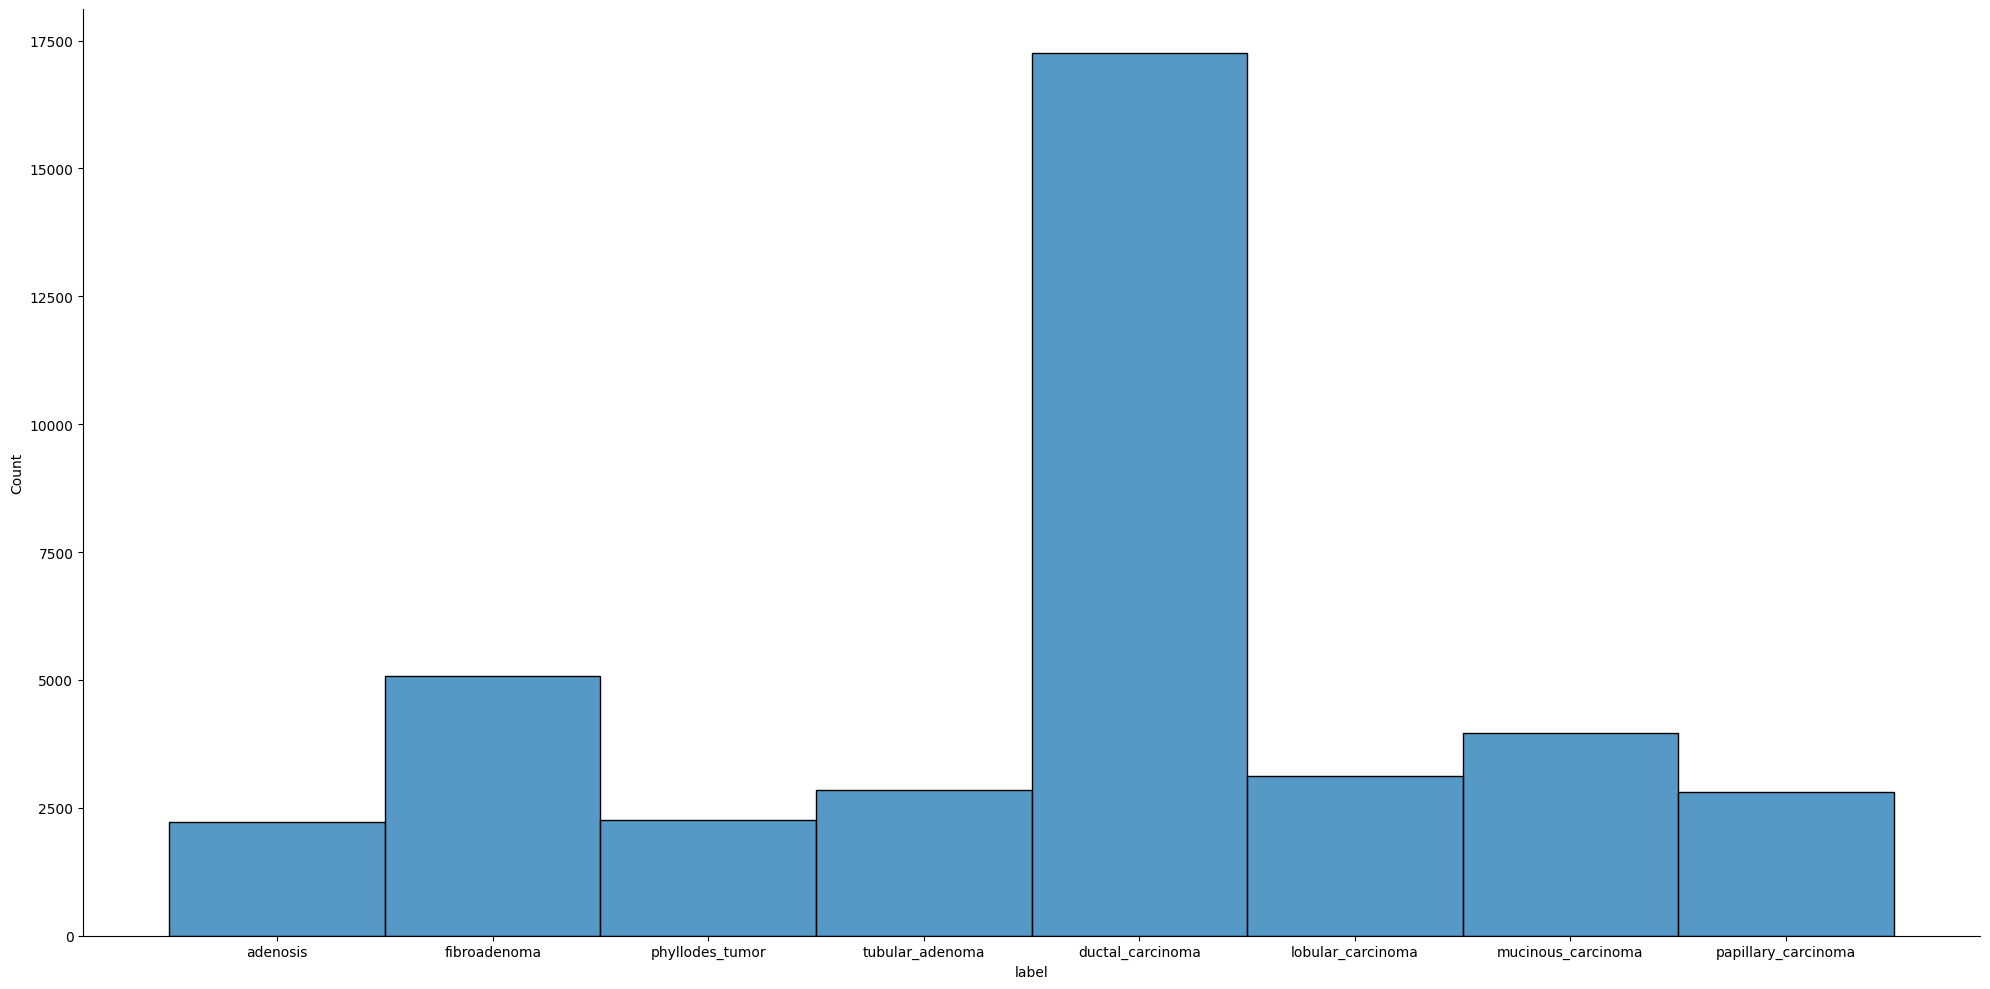

In [ ]:
ax = sns.displot(data=data, x='label', height=10, aspect=2)
print('Count of Benign : ', data[data.label == 'adenosis'].label.count())
print('Count of Benign : ', data[data.label == 'fibroadenoma'].label.count())
print('Count of Benign : ', data[data.label == 'phyllodes_tumor'].label.count())
print('Count of Benign : ', data[data.label == 'tubular_adenoma'].label.count())
print('Count of Malignant : ', data[data.label == 'ductal_carcinoma'].label.count())
print('Count of Malignant : ', data[data.label == 'lobular_carcinoma'].label.count())
print('Count of Malignant : ', data[data.label == 'mucinous_carcinoma'].label.count())
print('Count of Malignant : ', data[data.label == 'papillary_carcinoma'].label.count())

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(data["label_int"], dtype ="uint8" )

In [ ]:
Y_train.shape

(39545, 8)

In [ ]:
data.shape

(39545, 7)

In [ ]:
from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(
#     data, Y_train,
#     test_size=0.2, 
#     random_state=11
# )

x_train, x_test, y_train, y_test = train_test_split(data, Y_train, test_size=0.2, random_state=11)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=11) # 0.25 x 0.8 = 0.2

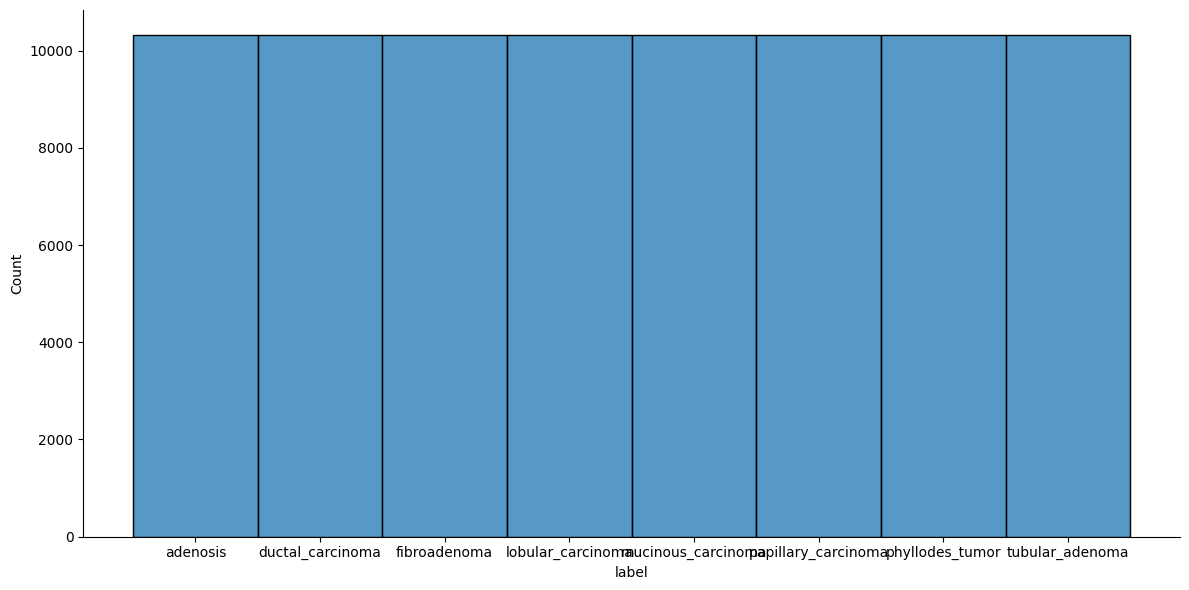

In [ ]:
#upsampling training dataset
max_count = np.max(x_train.label.value_counts())
min_count = np.min(x_train.label.value_counts())
x_train = x_train.groupby('label').sample(n=max_count, replace=True)
x_train = x_train.reset_index(drop=True)
x_train.label.value_counts()

ax = sns.displot(data=x_train, x='label',height=6, aspect=2)

In [ ]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return img, label

def aug_fn(image): 
    transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(p=0.5, limit=15),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1), brightness_by_max=True),
        A.RandomResizedCrop(p=0.8, height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
        A.Blur(p=0.3, blur_limit=(1, 1)),
    ])
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return aug_img

def augmentor(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

def view_image(ds, col=8, row=2, size=(25,7)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for images, label_int in ds.take(1):
        for i in range(col*row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[label_int[i]])
            plt.axis("off") 
    plt.tight_layout
    return None

In [ ]:
def training_history(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(history['loss']))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    return None

def decode_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])/255
    return img

def build_network(image_size):
    print('building model...')
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle_map['resnet_v2_50'], trainable=False, name='base_model'),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='softmax', name='classifier') 
    ],name=model_name)
    model.build((None, image_size, image_size, 3))
    model.summary()
    print('model loaded!!!')
    return model

In [ ]:
model_image_size_map = {
    'resnet_v2_50': 224,
    # add more models and their input sizes here
}



model_name = 'resnet_v2_50'
model_handle = model_handle_map.get(model_name)
IMAGE_SIZE = model_image_size_map.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 10
SAMPLE_SIZE = len(x_train)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}")

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Input size 224


In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+x_train.path, y_train))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+x_val.path, y_val))

train_ds = (
    train_loader.shuffle(len(x_train))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)

valid_ds = (
    valid_loader.shuffle(len(x_val))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
train_loader_img = tf.data.Dataset.from_tensor_slices((img_dir+x_train.path,x_train.label_int))
train_ds_img = (
    train_loader_img.shuffle(len(x_train))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)

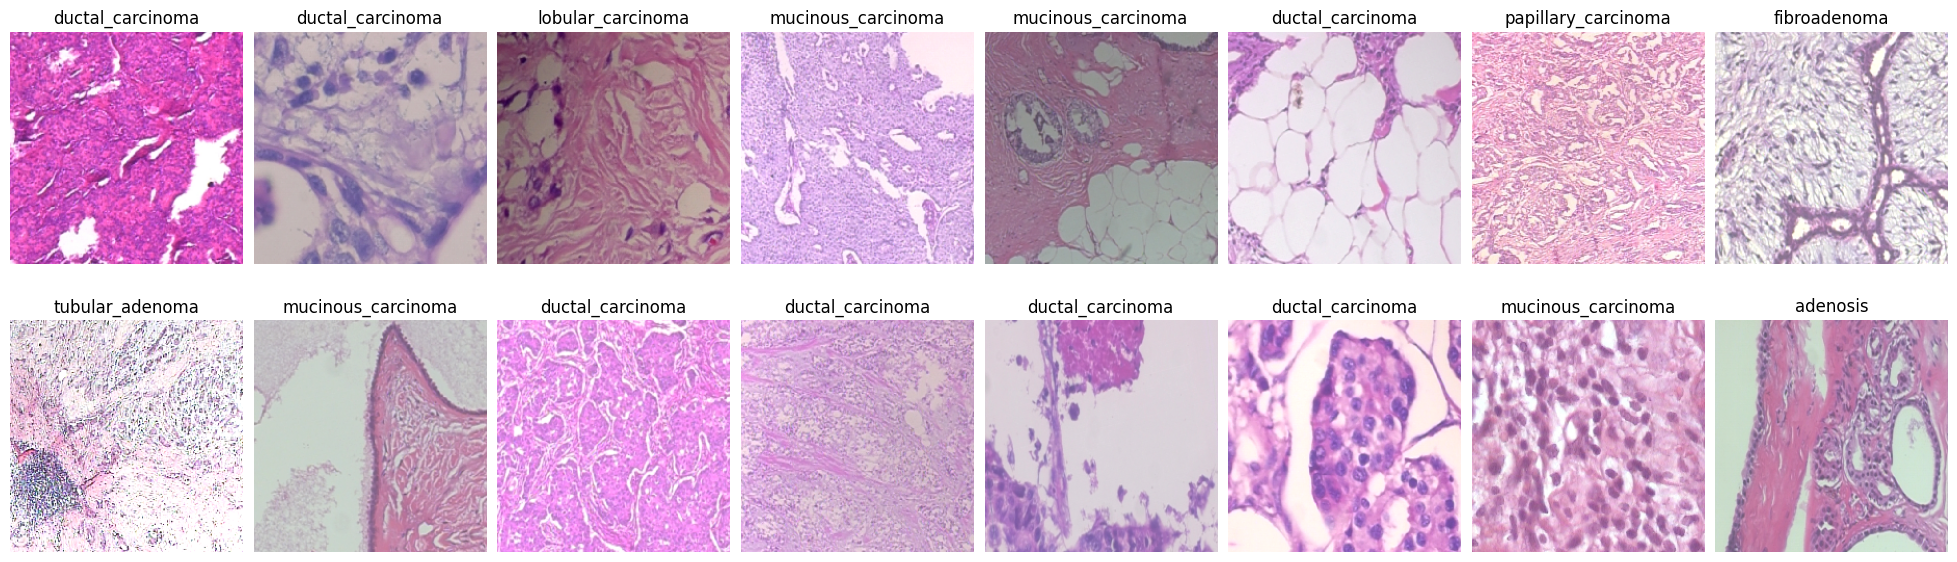

In [ ]:
view_image(train_ds_img)

In [ ]:
num_images = tf.data.experimental.cardinality(train_ds).numpy()
print(f"Number of images in train_ds: {num_images}")

Number of images in train_ds: 371


In [ ]:
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

In [ ]:
def gpu():
 with tf.device('/device:GPU:0'):
   tf.keras.backend.clear_session()
model = build_network(IMAGE_SIZE)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=2e-1,  maximal_learning_rate=7e-3, 
    step_size=3*(SAMPLE_SIZE//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler) , 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
)

history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [checkpoint_cb],
    validation_data=valid_ds,
)
#training_history(history.history)

building model...
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_model (KerasLayer)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                    

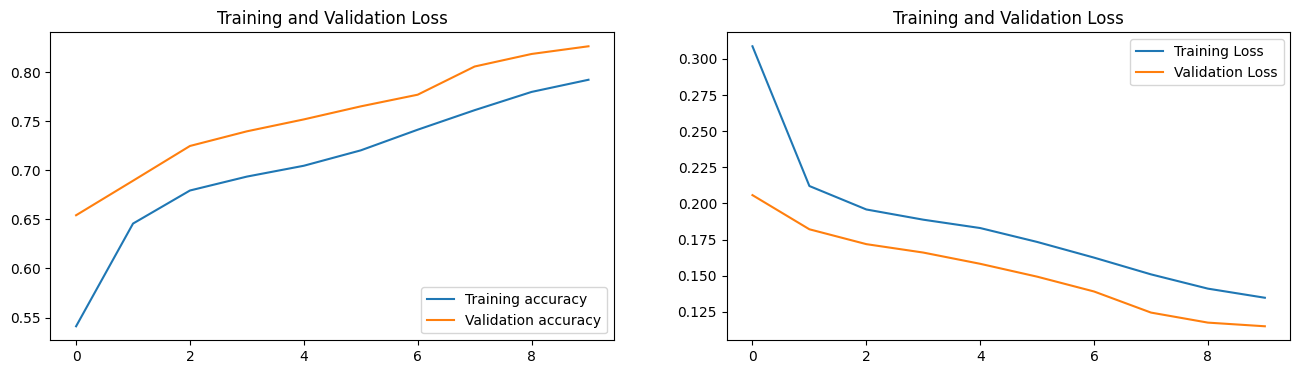

In [ ]:
training_history(history.history)

In [ ]:
x_train.shape

(23727, 7)

In [ ]:
im=np.zeros((23727,2048))
l=np.zeros((23727,1))

In [ ]:
m=hub.KerasLayer(model_handle_map['resnet_v2_50'], trainable=False, name='base_model')
j=0
for images, label in train_ds_img_p.take(371):
  i=m(images)
  im[j*64:(j+1)*64]=i
  if(label.shape[0]!=47):
    l[j*64:(j+1)*64]=label.numpy().reshape(64,1)
  else:
    l[j*64:(j+1)*64]=label.numpy().reshape(47,1)
  j=j+1

In [ ]:
y_val.shape[0]

7909

In [ ]:
im_val=np.zeros((7909,2048))
l_val=np.zeros((7909,1))

In [ ]:
j=0
for images, label in valid_ds_img_p.take(124):
  i=m(images)
  im_val[j*64:(j+1)*64]=i
  if(label.shape[0]!=37):
    l_val[j*64:(j+1)*64]=label.numpy().reshape(64,1)
  else:
    l_val[j*64:(j+1)*64]=label.numpy().reshape(37,1)
  j=j+1

In [ ]:
import pandas as pd
df=pd.DataFrame(im)
df.to_csv("train_features.csv")
df=pd.DataFrame(l)
df.to_csv("train_features_y.csv")

In [ ]:
df=pd.DataFrame(im_val)
df.to_csv("train_features.csv")
df=pd.DataFrame(l_val)
df.to_csv("train_features_y.csv")

In [ ]:
# Extract features from the last convolutional layer of the base model for SVM and KNN classifiers
from sklearn.svm import SVC

# Train an SVM classifier with radial bias kernel on extracted features for binary classification (benign vs malignant)
svm_clf = SVC(kernel='rbf',decision_function_shape='ovo')
svm_clf.fit(im, l)
y_pred_svm = svm_clf.predict(im_val)

from sklearn.metrics import confusion_matrix
cm_1=confusion_matrix(l_val,y_pred_svm)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'adenosis'),
  Text(0, 1.5, 'fibroadenoma'),
  Text(0, 2.5, 'phyllodes_tumor'),
  Text(0, 3.5, 'tubular_adenoma'),
  Text(0, 4.5, 'ductal_carcinoma'),
  Text(0, 5.5, 'lobular_carcinoma'),
  Text(0, 6.5, 'mucinous_carcinoma'),
  Text(0, 7.5, 'papillary_carcinoma')])

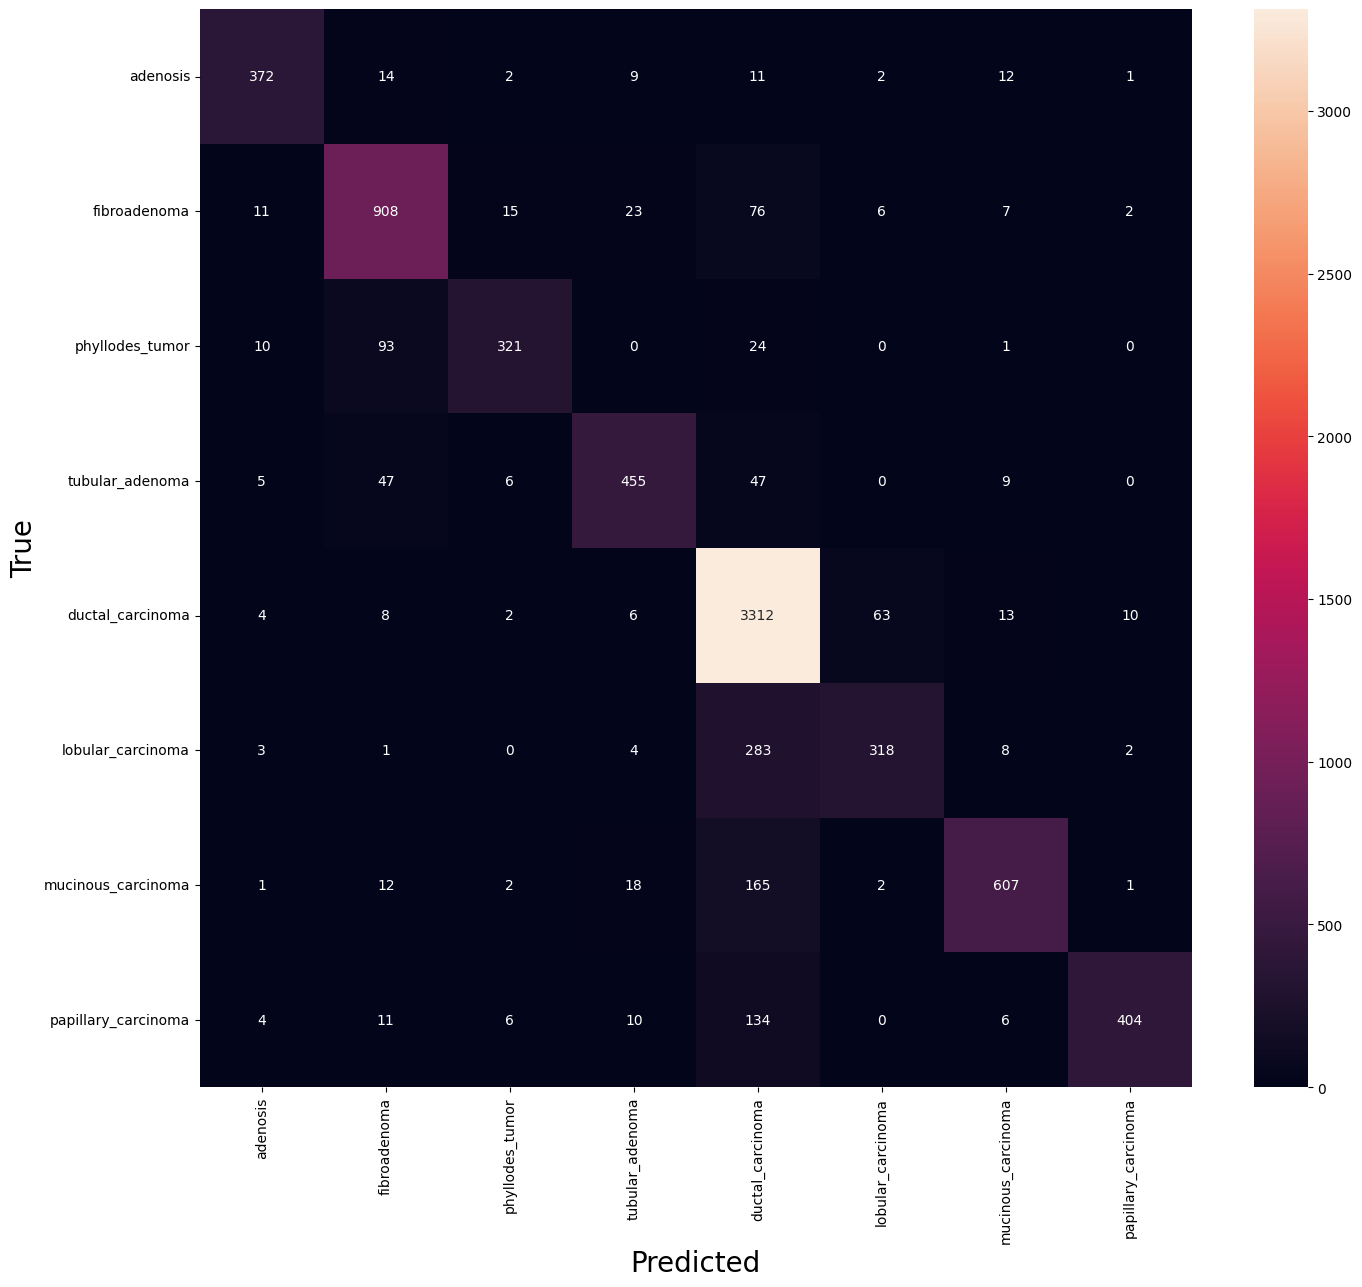

In [ ]:
import seaborn as sns
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm_1, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(l_val,y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       423
         1.0       0.83      0.87      0.85      1048
         2.0       0.91      0.71      0.80       449
         3.0       0.87      0.80      0.83       569
         4.0       0.82      0.97      0.89      3418
         5.0       0.81      0.51      0.63       619
         6.0       0.92      0.75      0.83       808
         7.0       0.96      0.70      0.81       575

    accuracy                           0.85      7909
   macro avg       0.88      0.77      0.82      7909
weighted avg       0.85      0.85      0.84      7909



In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(l_val,y_pred_svm))

0.7911869722319227


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN classifier on extracted features for binary classification (benign vs malignant)
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(im, l)
y_pred_knn = knn_clf.predict(im_val)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(l_val,y_pred_knn)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'adenosis'),
  Text(0, 1.5, 'fibroadenoma'),
  Text(0, 2.5, 'phyllodes_tumor'),
  Text(0, 3.5, 'tubular_adenoma'),
  Text(0, 4.5, 'ductal_carcinoma'),
  Text(0, 5.5, 'lobular_carcinoma'),
  Text(0, 6.5, 'mucinous_carcinoma'),
  Text(0, 7.5, 'papillary_carcinoma')])

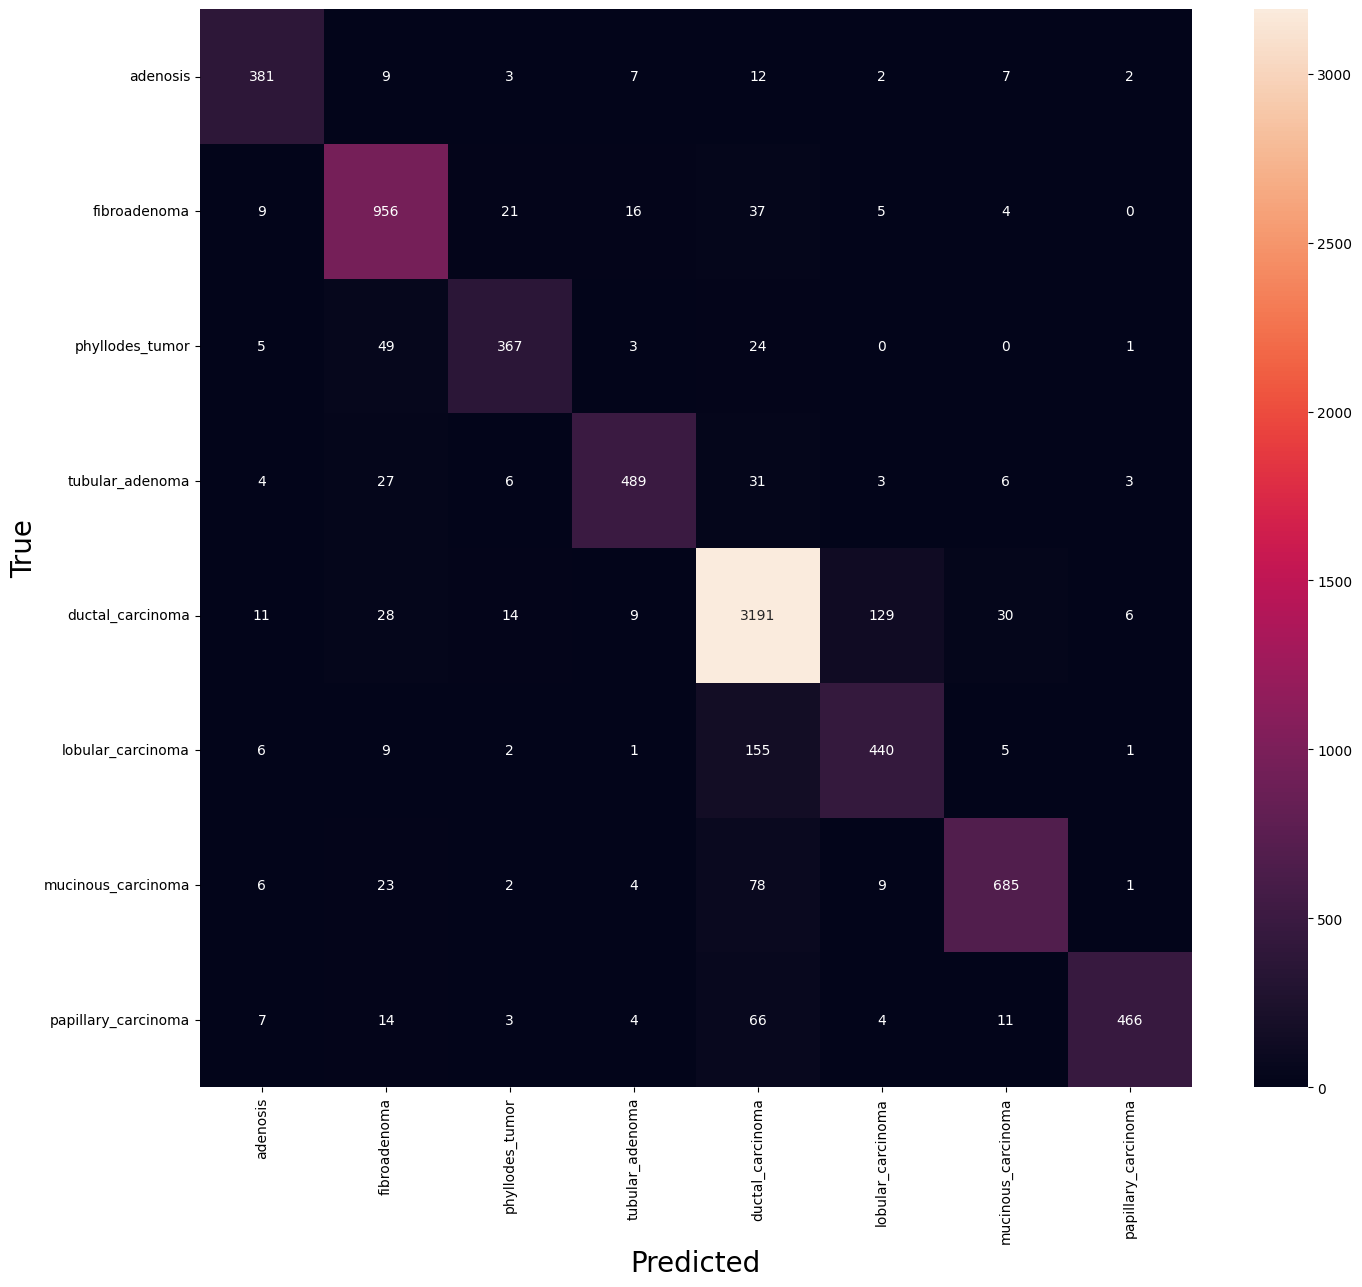

In [ ]:
import seaborn as sns
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(l_val,y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89       423
         1.0       0.86      0.91      0.88      1048
         2.0       0.88      0.82      0.85       449
         3.0       0.92      0.86      0.89       569
         4.0       0.89      0.93      0.91      3418
         5.0       0.74      0.71      0.73       619
         6.0       0.92      0.85      0.88       808
         7.0       0.97      0.81      0.88       575

    accuracy                           0.88      7909
   macro avg       0.88      0.85      0.86      7909
weighted avg       0.88      0.88      0.88      7909



In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(l_val,y_pred_knn))

0.8434299922906237
